Set up the imports

# Section 1: Study Objective
This project studies the problem of trying to model the national GDP using other major economic indicators using ML techniques. The main questions are:

**Question 1.** Can ML techniques be employed to predict the GDP using some major economic indicators?

**Question 2.** What data can we obtain and which ML technique best suit this goal?

**Question 3.** With the chosen technique, what's the optimal model and how does it perform?

In [1]:
# Setup the imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import re

# Section 2: Data Source and understanding

The data comes from the World Bank economic indicators https://databank.worldbank.org/indicator/NY.GDP.PCAP.CD/1ff4a498/Popular-Indicators# This dataset contains the major economic indicators from 2000. 

In [2]:
# Load the data and explore
fpath = f"./WorldBankEconomicData.csv"
df = pd.read_csv(fpath)


# Section 3: Data Preparation

The raw data table needs to be transformed and reshaped for use. 
Select a subset of the data Series as features and the target will be GDP. We'll rename the long Series Names to shorter names. Also select a subset of countries by their 'Country Code' to be included here.

We will define a few functions to aid the data transformations task first.


In [3]:
def get_data_for_country(df : pd.DataFrame, series_to_keep : dict, country_code: str):
    '''
    Extract data from the given DataFrame according the criterias in Series Name and Country Code and
    transpose the data

    Args:
        df (pd.DataFrame): The input raw data loaded from CSV downloaded from World Bank
        series_to_keep (dict): The Series Names and map to their short hand to keep from df
        country_code (str): The Country Code for the data kept.
    Returns: 
        pd.DataFrame whose columns are the specified data Series Name short hand and rows are 
        instances for a given year.
    '''

    # select by 'Country Code' then transpose the data so that data per Series will be in columns
    # instead of rows. 
    country_df = df[df['Country Code']==country_code]
    country_df = country_df.T

    # set the column names to the Series Names instead of numeric values
    c_series = country_df.loc['Series Name'].values.tolist()
    country_df.columns = c_series

    # Now only keep the series as specified
    country_df = country_df[[nm for nm, _ in series_to_keep.items() ]]
    country_df.drop(['Series Name', 'Series Code', 'Country Name', 'Country Code'])

    # Rename Series Names to their short hands
    country_df.rename(columns=series_to_keep, inplace=True)

    #ensure data are numeric
    country_df = country_df.apply(pd.to_numeric, errors = 'coerce')
    country_df['Country'] = country_code

    # optional cleaning up the Year column, 2004 [YR2004] --> 2004
    old_ex = r"(\d\d\d\d)\s\[YR\d\d\d\d\]"
    years = [re.sub(old_ex, r"\1", s) for s in country_df.index.tolist()]
    country_df['Year'] = years
    country_df = country_df.set_index('Year')
    
    return country_df

def get_cleaned_data(df : pd.DataFrame, series_to_keep : dict, country_list : list):
    '''
    Extract data from the given DataFrame according the criterias in Series Names map and 
    Country Codes and transpose the data

    Args:
        df (pd.DataFrame): The input raw data loaded from CSV downloaded from World Bank
        series_to_keep (dict): The Series Names and map to their short hand to keep from df
        country_list (list): List of the Country Codes for the data desired.
    Returns: 
        pd.DataFrame whose columns are the specified data Series Name short hand and rows are 
        instances for a given year.    
    '''
    return pd.concat(
        [get_data_for_country(df, series_to_keep, c) for c in country_list]
    )

## Feature Selection and Preprocessing

1. All data are numeric continuous variables. No category fetures.
2. We select the features candidates. This is a larger set based on prelimenary intuition.
3. Remove instances of missing data. Given the authority of the data quality of the World Bank, imputing numbers for a missing major economic indicator for a country on a certain year would be too arbitrary.

In [4]:
# Candidate features and give them a shorter name for convenience
feature_names = {
    'Energy use (kg of oil equivalent per capita)' : 'energy_use',
    'Electric power consumption (kWh per capita)' : 'power_use',
    'Inflation, GDP deflator (annual %)' : 'inflation',
    'Agriculture, forestry, and fishing, value added (% of GDP)' : 'agriculture',
    'Industry (including construction), value added (% of GDP)' : 'industry',
    'Exports of goods and services (% of GDP)' : 'exports',
    'Imports of goods and services (% of GDP)' : 'imports',
    'Market capitalization of listed domestic companies (% of GDP)' : 'market_cap',
    'Military expenditure (% of GDP)' : 'military_spending',
    'Merchandise trade (% of GDP)' : 'trades',
    'Foreign direct investment, net inflows (BoP, current US$)' : 'foreign_inv',
    'Inflation, consumer prices (annual %)' : 'CPI'
}
# set the target
target = 'GDP'

# list of Country Codes for the study. This can be re-configured easily.
country_codes = [
    'ARG', 'AUT', 'AUS', 'BEL', 'BRA', 'CAN', 'DNK','FIN', 'FRA', 'DEU', 'GRC',
    'ITA', 'JPN', 'MEX', 'NLD', 'NZL', 'NOR', 'SGP', 'SWE', 'CHE', 'GBR', 'USA'
]

processed_df = get_cleaned_data(df, feature_names|{'GDP (current US$)' : 'GDP'}, country_codes)
processed_df.reset_index(inplace=True)
# drop information only non-numeric columns and remove NaN
processed_df = processed_df.drop(columns=['Country', 'Year']).dropna()

## Data Exploration

1. Plot the pair-wise scatter plots. Individual features do not show linear relationship with GDP at all.
2. Plot of the correlation matrix shows the top 3 features most correlated to GDP is ['foreign_inv', 'military_spending', 'trades']. 


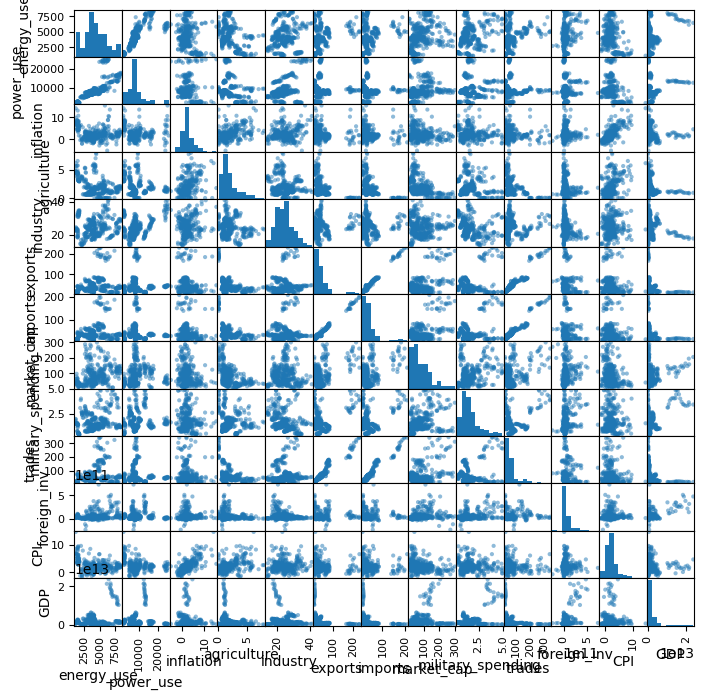

In [5]:
from pandas.plotting import scatter_matrix

scatter_matrix(processed_df, figsize=(8, 8), diagonal='hist')
plt.show()


*The correlation matrix also reveals that trade, imports and exports have near perfect correlation among them. It suggests only one should be used as features.*

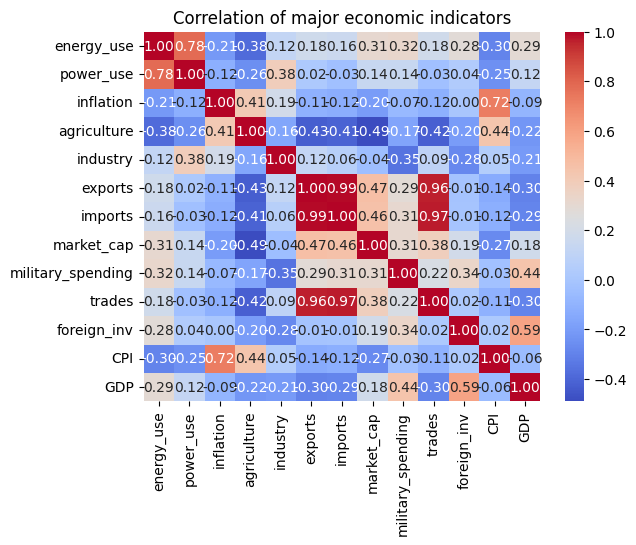

In [6]:
# plot the correlation matrix heatmap
corr_matrix = processed_df.corr()
plt.figure() # Adjust figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation of major economic indicators')
plt.show()

# Section 4: Data Modeling

We will use RandomForestRegressor to predict target using a selection of features and evaluate the model performance.

**Question 1.** Given the high correlation between imports, exports and trades, should only one of these be selected?

**Question 2.** Do we need so many features, complicating the model? 

**Question 3.** What is the optimal selection of the features in the trade off between model parsimony and performance?


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree # if plotting a tree
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score

def run_regression(X, y, max_depth=3, sample_tree_plot=False):
    ''' 
    Define a function to run the RandomForestRegression for given (X, y) and return the Root Mean Square Errors 
    and R-squares for both the training and test sets.

    Args: 
        X: Matrix like input data for the features
        y: target values compatible with X
        max_depth: optional model tuning parameter

    Returns:
        The model performance metrics
    '''

    # split the dataset into training and test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42
    )

    # Build and train the model
    regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
    regr.fit(X_train, y_train)

    # (optional) plot a sample decision tree inside the forest
    if sample_tree_plot:
        sample_tree = regr.estimators_[0]
        plt.figure(figsize=(20, 15)) # Adjust figure size for better readability
        tree.plot_tree(sample_tree, 
                       feature_names=[f'feature_{i}' for i in range(X.shape[1])], # Provide feature names
                       filled=True, 
                       rounded=True, 
                       fontsize=10)
        plt.title("Decision Tree from Random Forest Regressor")
        plt.show()


    # Use the model to do prediction on both the training and test data to check model performance metrics
    y_pred_train = regr.predict(X_train)
    RMSE_train = root_mean_squared_error(y_pred_train, y_train)
    r2_train = r2_score(y_pred_train, y_train)

    y_pred_test = regr.predict(X_test)
    RMSE_test = root_mean_squared_error(y_pred_test, y_test)
    r2_test = r2_score(y_pred_test, y_test)

    # package the return for later evaluation
    ret = pd.DataFrame(
        {
            'Dataset' : ['Training', 'Test'],
            'RMSE':[RMSE_train, RMSE_test],
            'R-Square' : [r2_train, r2_test],
        }
    )

    return ret


# Section 5: Evaluation

We will assess the model based on the following experiments
1. Including all numerical features. There are no categorical features.
2. Choose only the top 3 features most correlated with the target.
3. Investigate if 2 or 1 features would provide an adequate model.

## Include all numeric features

In [8]:
# Use all features
use_features = [nm for _, nm in feature_names.items()]
used_df = processed_df[use_features+[target]]

X = used_df[[nm for nm in used_df.columns if nm != target]]
y = used_df[target]
full_model = run_regression(X, y)
full_model.Dataset = [elem + '_ALL' for elem in full_model.Dataset.values.tolist()]
full_model

,Dataset,RMSE,R-Square
0,Training_ALL,8.331751e+11,0.942403
1,Test_ALL,1.049760e+12,0.902060


## Remove duplicate features
The 3 features imports/exports/trades have near perfect correlations among them.
How would the model perform if only one, say trades, is included in the feature set?

Removing imports/exports and keep only trades result in nearly the same performance.

In [9]:
# Remove exports/imports which are 99% correlated to trades
use_features = [nm for _, nm in feature_names.items() if 'ports' not in nm]
used_df = processed_df[use_features+[target]]

X = used_df[[nm for nm in used_df.columns if nm != target]]
y = used_df[target]
clean_model = run_regression(X, y)
clean_model.Dataset = [elem + '_CLEAN' for elem in full_model.Dataset.values.tolist()]
clean_model

,Dataset,RMSE,R-Square
0,Training_ALL_CLEAN,9.038310e+11,0.929888
1,Test_ALL_CLEAN,1.247267e+12,0.823720


## Use only the top 3 features
How does the model perform if only the 3 features most correlated to the target are included?

With only 3 features included in the model, the model performs nearly as good as the "full" model. But this is much prefered due to its simplicity.

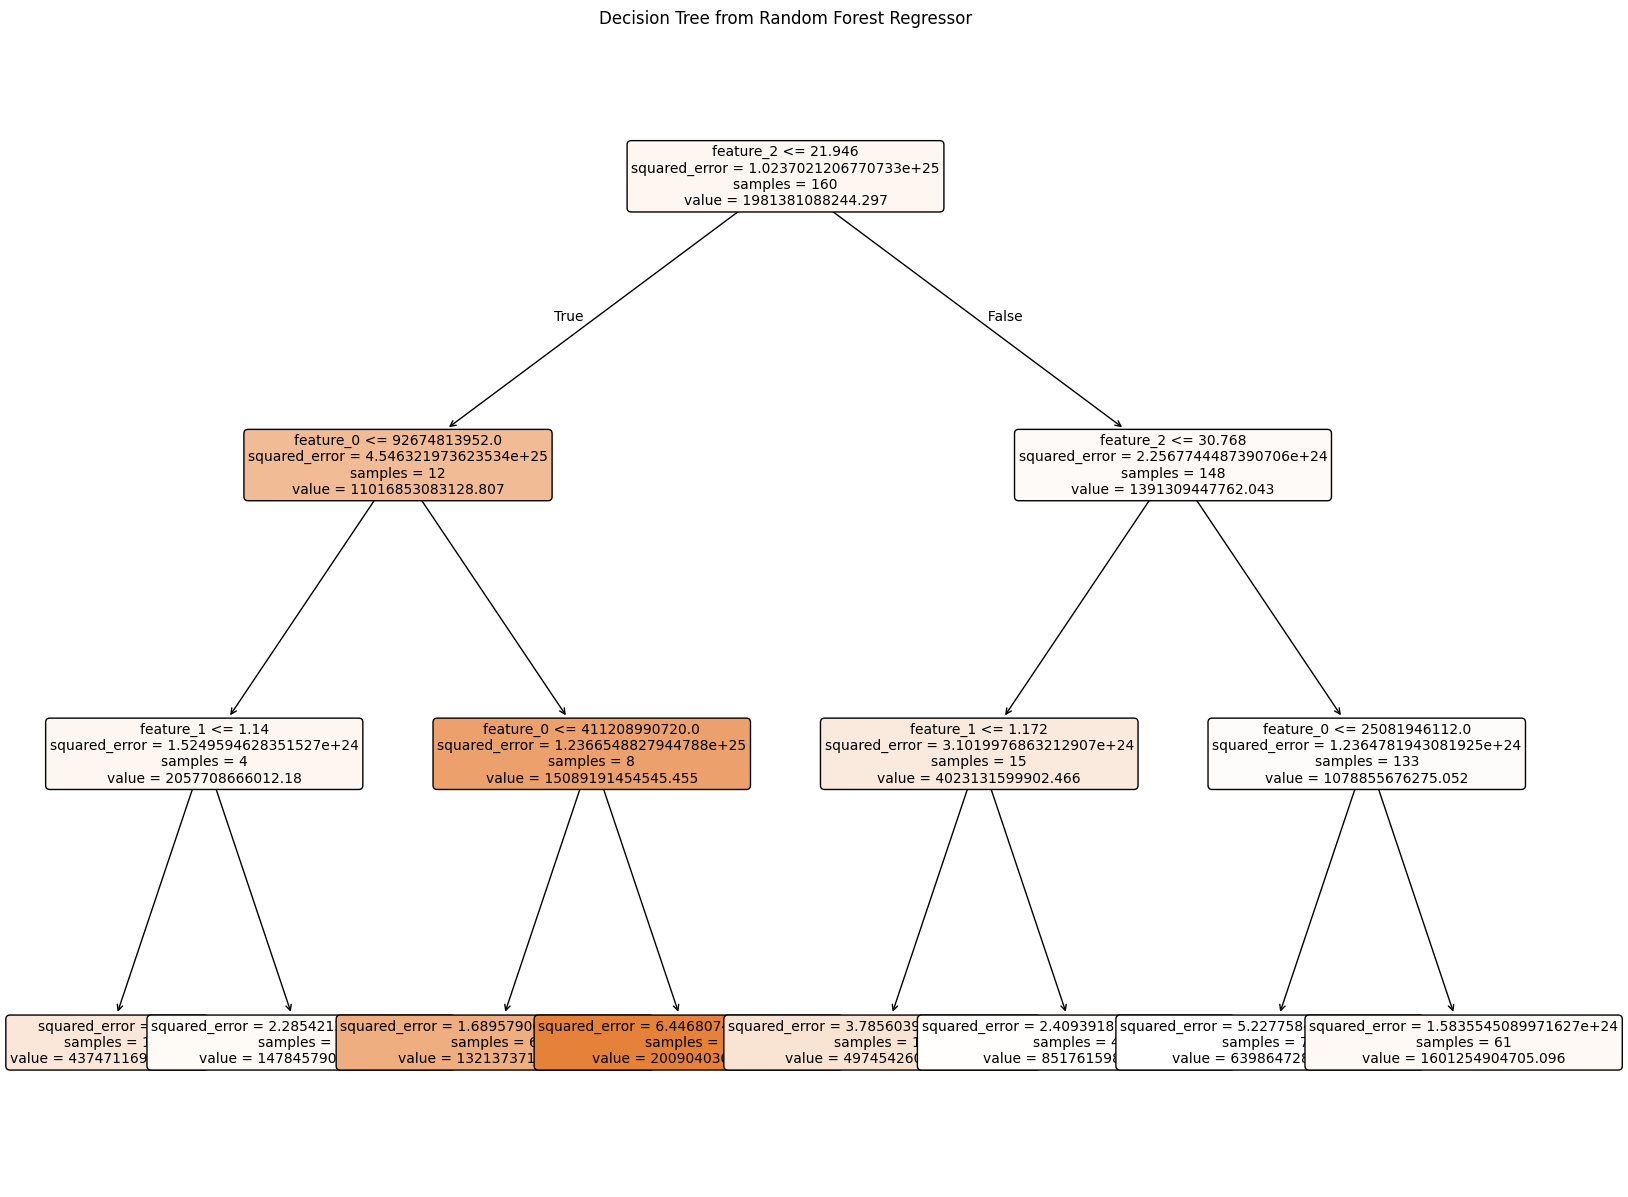

,Dataset,RMSE,R-Square
0,Training_ALL_TOP3,1.023939e+12,0.910897
1,Test_ALL_TOP3,1.386265e+12,0.810148


In [10]:
# Only use the top 3 features by their correlations with the target
use_features = ['foreign_inv', 'military_spending', 'trades']
used_df = processed_df[use_features+[target]]

X = used_df[[nm for nm in used_df.columns if nm != target]]
y = used_df[target]
top3_model = run_regression(X, y, sample_tree_plot=True)
top3_model.Dataset = [elem + '_TOP3' for elem in full_model.Dataset.values.tolist()]
top3_model

## Use less than 3 features
How does the model perform with only the 2 features most correlated to the target?

With only the top 2 features, the model performed OK with the training set, but poorly with the test set. This is a sign of overfitting.

In [11]:
# Only use the top 2 features by their correlations with the target
use_features = ['foreign_inv', 'military_spending']
used_df = processed_df[use_features+[target]]

X = used_df[[nm for nm in used_df.columns if nm != target]]
y = used_df[target]
top2_model = run_regression(X, y)
top2_model.Dataset = [elem + '_TOP2' for elem in full_model.Dataset.values.tolist()]
top2_model


,Dataset,RMSE,R-Square
0,Training_ALL_TOP2,1.297673e+12,0.848006
1,Test_ALL_TOP2,2.004354e+12,0.381594


## Conclusion

The RandomForestRegressor provide a reasonable model for GDP using the major economic indicators foreign investment,
military spending and trade volume.

In [12]:
comparison = pd.concat([full_model, clean_model, top3_model, top2_model], ignore_index=True)
comparison.set_index('Dataset')
comparison

,Dataset,RMSE,R-Square
0,Training_ALL,8.331751e+11,0.942403
1,Test_ALL,1.049760e+12,0.902060
2,Training_ALL_CLEAN,9.038310e+11,0.929888
3,Test_ALL_CLEAN,1.247267e+12,0.823720
4,Training_ALL_TOP3,1.023939e+12,0.910897
5,Test_ALL_TOP3,1.386265e+12,0.810148
6,Training_ALL_TOP2,1.297673e+12,0.848006
7,Test_ALL_TOP2,2.004354e+12,0.381594
